📦 Imports & Setup

In [3]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import json
import matplotlib.pyplot as plt
import os


🔧 Load Model & Tokenizer

In [2]:
class BERTToRotation(nn.Module):
    def __init__(self, output_dim=15):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.linear(x)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased")
bert.eval()

model = BERTToRotation(output_dim=15)


📁 Load Dataset

In [3]:
class GestureDataset(Dataset):
    def __init__(self, path, tokenizer):
        with open(path, "r") as f:
            self.samples = json.load(f)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        gesture = self.samples[idx]["gesture"]
        vec = self.samples[idx]["rotation_vector"]
        if not isinstance(vec, list) or len(vec) != 15:
            raise ValueError(f"Invalid vector: {vec}")
        target = torch.tensor(vec, dtype=torch.float32).reshape(15)  # ✅ Ensure correct shape

        tokens = self.tokenizer(
            gesture,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=10,
        )
        return {
            "input_ids": tokens["input_ids"].squeeze(0),
            "attention_mask": tokens["attention_mask"].squeeze(0),
            "target": target
        }

dataset_path = "../../public/gesture_dataset_arr(15).json"  # adjust if needed
dataset = GestureDataset(dataset_path, tokenizer)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

🧠 Training Loop

In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
model.train()

losses = []
epochs = 30

for epoch in range(epochs):
    total_loss = 0.0
    for batch in loader:
        with torch.no_grad():
            pooled = bert(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            ).pooler_output
        pred = model(pooled)
        loss = loss_fn(pred, batch["target"])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.6f}")


Epoch 1: Loss = 1.043564
Epoch 2: Loss = 0.915799
Epoch 3: Loss = 0.804214
Epoch 4: Loss = 0.718362
Epoch 5: Loss = 0.635468
Epoch 6: Loss = 0.573802
Epoch 7: Loss = 0.527829
Epoch 8: Loss = 0.485300
Epoch 9: Loss = 0.441588
Epoch 10: Loss = 0.416884
Epoch 11: Loss = 0.402844
Epoch 12: Loss = 0.382741
Epoch 13: Loss = 0.375822
Epoch 14: Loss = 0.363513
Epoch 15: Loss = 0.359179
Epoch 16: Loss = 0.354606
Epoch 17: Loss = 0.353550
Epoch 18: Loss = 0.351271
Epoch 19: Loss = 0.350118
Epoch 20: Loss = 0.347248
Epoch 21: Loss = 0.346122
Epoch 22: Loss = 0.344689
Epoch 23: Loss = 0.343956
Epoch 24: Loss = 0.342409
Epoch 25: Loss = 0.340684
Epoch 26: Loss = 0.340168
Epoch 27: Loss = 0.339217
Epoch 28: Loss = 0.338599
Epoch 29: Loss = 0.335970
Epoch 30: Loss = 0.334468


 📉 Plot Loss Curve

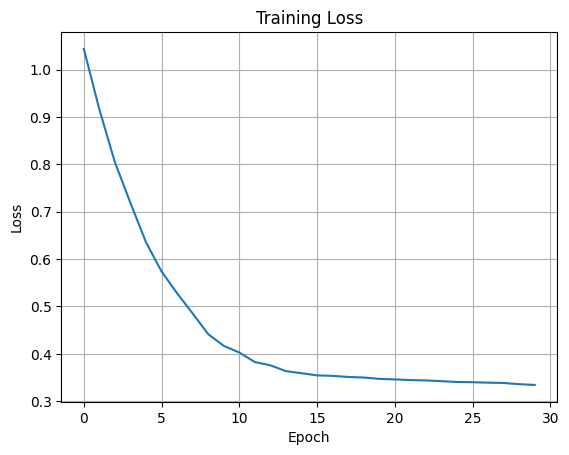

In [5]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()

💾 Save Model

In [6]:
torch.save(model.state_dict(), "bert_to_rotation.pth")
print("✅ Model saved to bert_to_rotation.pth")

✅ Model saved to bert_to_rotation.pth
